In [106]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

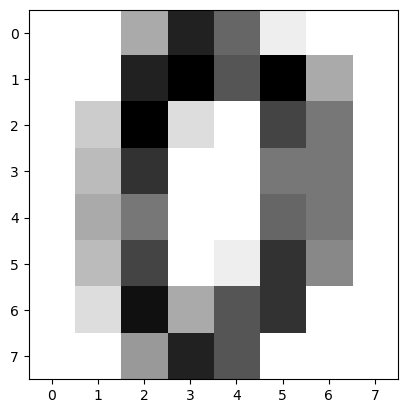

In [110]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

In [111]:
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [116]:
# 데이터를 PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [118]:
# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [120]:
# DNN 모델 정의
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN()

In [122]:
# 손실함수와 최적화기 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [124]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            # 이진 분류
            # predicted = (torch.sigmoid(outputs) >= 0.5).float()

            # 다중 분류
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 1.2414, Accuracy: 87.78%
Epoch 2/20, Loss: 0.2778, Accuracy: 95.56%
Epoch 3/20, Loss: 0.1484, Accuracy: 96.11%
Epoch 4/20, Loss: 0.1138, Accuracy: 96.67%
Epoch 5/20, Loss: 0.0825, Accuracy: 97.22%
Epoch 6/20, Loss: 0.0709, Accuracy: 97.22%
Epoch 7/20, Loss: 0.0512, Accuracy: 97.78%
Epoch 8/20, Loss: 0.0442, Accuracy: 97.78%
Epoch 9/20, Loss: 0.0360, Accuracy: 97.50%
Epoch 10/20, Loss: 0.0334, Accuracy: 96.94%
Epoch 11/20, Loss: 0.0237, Accuracy: 97.22%
Epoch 12/20, Loss: 0.0239, Accuracy: 97.78%
Epoch 13/20, Loss: 0.0179, Accuracy: 97.22%
Epoch 14/20, Loss: 0.0151, Accuracy: 97.50%
Epoch 15/20, Loss: 0.0131, Accuracy: 97.22%
Epoch 16/20, Loss: 0.0091, Accuracy: 97.78%
Epoch 17/20, Loss: 0.0059, Accuracy: 97.78%
Epoch 18/20, Loss: 0.0064, Accuracy: 97.50%
Epoch 19/20, Loss: 0.0047, Accuracy: 97.78%
Epoch 20/20, Loss: 0.0044, Accuracy: 98.06%
Training complete.


In [125]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  1]
 [ 0  0  0  0  0 32  2  0  0  1]
 [ 0  0  0  0  0  0 41  0  0  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  1  0  0  0  0  0  0 37  0]
 [ 0  0  0  0  0  1  0  0  1 25]]
F1 Score: 0.98
Precision: 0.98
Recall: 0.98
Specificity: 1.00


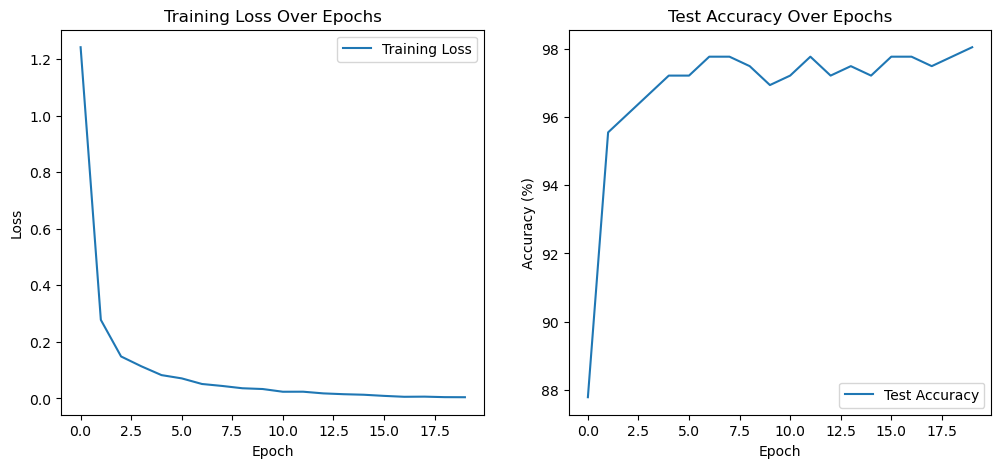

In [126]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()